# Projet OT5: Parallélisation de micro-aevol

## Adrien Jaillet - Novembre 2022

Tout ce projet tourne uniquement sur machine Linux.

### Présentation des fichiers

Le dossier est composé de plusieurs sous-dossiers. Chaque sous-dossier correspond à une nouvelle version de micro-aevol. La version v0 correspond à la version initiale. 

J'ai choisi d'axer ma parallélisation sur le GPU, c'est la partie qui m'intéressait le plus.

### Configuration

Afin que les programmes puissent compiler sur votre machine, vous devez modifier mettre dans une variable d'environement nommé MICRO_AEVOL_PROJECT_DIRECTORY le chemin vers la racine du projet.

In [1]:
!export MICRO_AEVOL_PROJECT_DIRECTORY=/home/ajaillet/Documents/5IF/OT5/micro-aevol2-master
!printenv MICRO_AEVOL_PROJECT_DIRECTORY

/home/ajaillet/Documents/5IF/OT5/micro-aevol2-master


Si les deux lignes de commandes précédentes n'ont pas donné de sortie, vous devez les lancer dans le terminal avant d'ouvrir jupyter-notebook.

### V0: Vérification de la cohérence des résultats CPU / GPU et comparaison des résultarts

#### Cohérence des résultats

Le script suivant vérifie que les résultats n'ont pas été érronés durant les modifications. Les compilations se refont si besoin au cours des scripts pythons:

In [3]:
import subprocess
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v0/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

#### Analyse des performances

In [13]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000]
nbValues = 10
values = {"v0_cpu": [], "v0_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_both.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_gpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

f = open("stats_v0_v0.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
version = "v0_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
f.close()

print("Done")

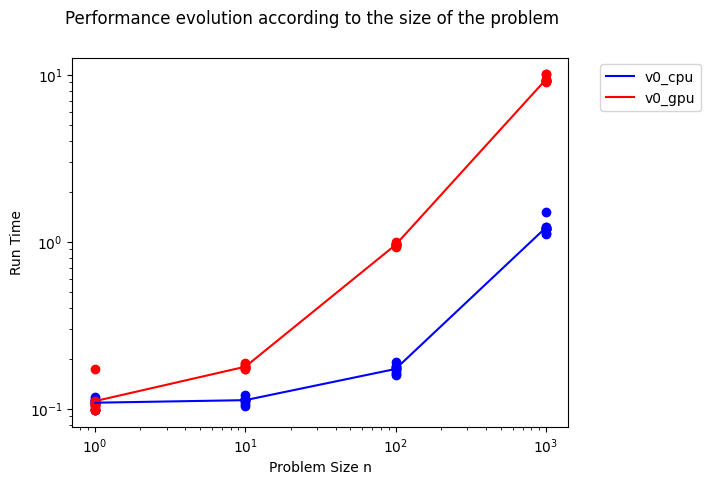

In [5]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v0_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v0_gpu" : "red"}
versions = ["v0_cpu", "v0_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

On observe avec ce graph que la version GPU qui nous est donnée est beaucoup plus lente que la version CPU de base. Notre objectif va être d'améliorer cette version jusqu'à ce que l'on soit au moins aussi bon que la version cpu de base.

### V1

Premièrement, en utilisant le GPU, nous remarquons que nous passons beaucoup de temps dans le nettoyage des données à la fin du programme. (quasiment 3 secondes)

<br />
<br />
<br />

![PB1](images/problems_clean.png)

<br />
<br />
<br />

En parallélisant cette partie, nous gagnons déjà quasiment 3 secondes sur les résultats.

<br />
<br />
<br />

![PB2](images/after_first_clean.png)

<br />
<br />
<br />

Ensuite nous remarquons que nous passons une grosse partie de notre temps dans la fonction "sparse_meta" (30%), nous allons donc paralléliser cette fonction.

<br />
<br />
<br />

![PB3](images/pb_sparse_meta_data.png)

<br />
<br />
<br />

En parallélisant cette partie, nous réduisons le temps passé dans cette fonction (qui était de 30%) à 10% environ.

<br />
<br />
<br />

![PB4](images/after_parallelization_sparse.png)

<br />
<br />
<br />

#### Cohérence des résultats

Le script suivant vérifie que les résultats n'ont pas été erronés durant les modifications. Les compilations se refont si besoin au cours des scripts pythons:

In [15]:
import subprocess
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v1/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

#### Analyse des performances

In [16]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000, 10000]
nbValues = 10
values = {"v0_cpu": [], "v0_gpu": [], "v1_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_both.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_gpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

os.chdir("v1/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v1_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

f = open("stats_v0_v1.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
version = "v0_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
version = "v1_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
f.close()

print("Done")

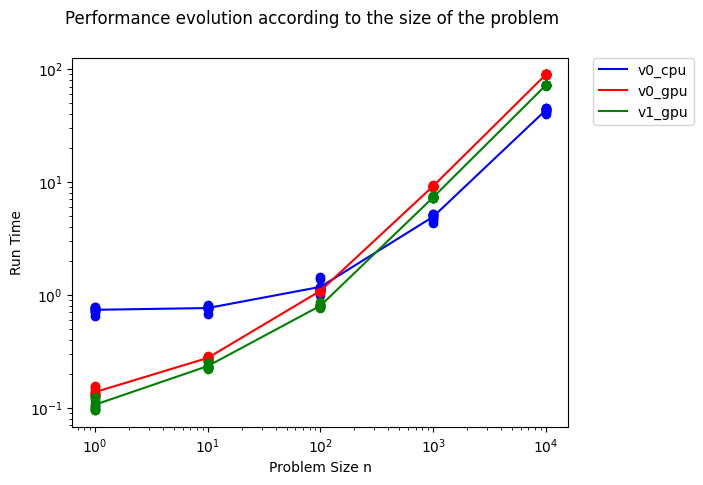

In [6]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v1_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v0_gpu" : "red", "v1_gpu": "green"}
versions = ["v0_cpu", "v0_gpu", "v1_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Nous remarquons que notre nouvelle version GPU est meilleure que la version CPU de base jusqu'à ce que l'on dépasse les n=100. Cela est dû à la mauvaise latence de notre code en GPU. Dans la fonction "evaluate_population", nous nous synchronisons tous les blocks à chaque fin de fonction, ce qui rajoute énormément de temps de latence. Nous allons donc enlever ces synchronisations dès que nous le pouvons. Nous gardons une synchronisation avant la fonction "clean_metadata" et la fonction "gather_genes" car ces deux fonctions sont les seules qui n'utilisent pas un block par individu. 

(N.B: La version v0_gpu à des meilleures performances que sur le graph précédent car nous avons appliqué la modification concernant la fonction "clean_population" à cette version aussi).

#### Cohérence des résultats

Le script suivant vérifie que les résultats n'ont pas été erronés durant les modifications. Les compilations se refont si besoin au cours des scripts pythons:

In [18]:
import subprocess
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v2/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

#### Récupération des résultats

In [19]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000, 10000]
nbValues = 10
values = {"v0_cpu": [], "v1_gpu": [], "v2_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_cpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

os.chdir("v1/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v1_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

os.chdir("v2/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v2_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

f = open("stats_v0_v1_v2.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
    
version = "v1_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
version = "v2_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
f.close()

print("Done")

#### Analyse des performances:

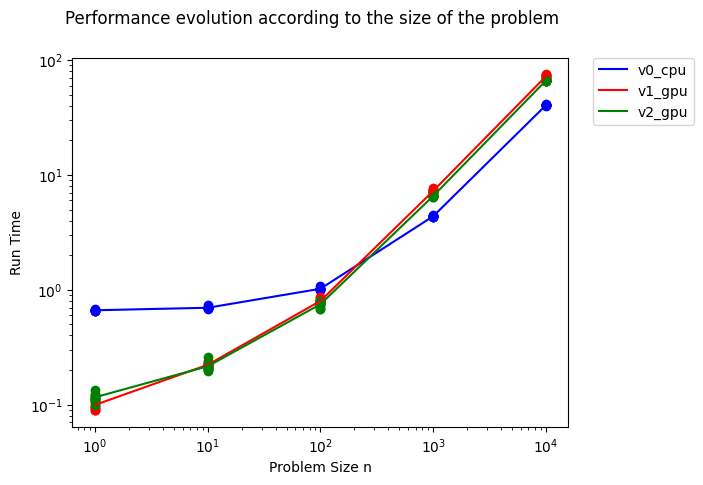

In [37]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v1_v2_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v1_gpu" : "red", "v2_gpu": "green"}
versions = ["v0_cpu", "v1_gpu", "v2_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Nous remarquons que nous gagnons un peu de temps graĉe à cette modification. Sur ce graph, le résultat n'est pas très marquant à cause de l'échelle logarithmique.
Si vous passez à un graph avec une échelle linéaire (supprimez les lignes  "ax1.set_yscale('log')" et "ax1.set_xscale('log')"), nous remarquons que le gain induit par cette modification est linéaire en fonction du temps, et qu'il représente plusieurs secondes lorsque nous sommes autour de n = 10000. Ce qui n'est pas négligeable.

Retournons à notre analyse avec le profiler...

<br />
<br />
<br />

![PB4](images/pb_v3_gather_gene.png)

<br />
<br />
<br />

Nous remarquons que les fonctions gather_gene et clean_metadata prennent énormément de temps (respectivement 20% et 11% du temps total). Cela est dû au fait que ces fonctions font des "new" et des "delete". Ce sont des opérations qui ne sont vraiment pas optimisées sur un GPU. Après quelques modifications du code, en rajoutant des cudaMalloc et en modifiant la phase d'initialisation, nous avons pu enlever tous les "new" et les "delete" dans la partie GPU du code.

<br />
<br />
<br />

![PB4](images/after_fix_clean_metadata.png)

<br />
<br />
<br />

Le temps pris par ces fonctions devient vraiment minime (2.3% pour gather_gene et 0.3% pour clean meta_data).

#### Cohérence des résultats

In [8]:
import subprocess
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v3/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

#### Récupération des résultats

In [25]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000, 10000]
nbValues = 10
values = {"v0_cpu": [], "v1_gpu": [], "v2_gpu": [], "v3_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_cpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

os.chdir("v1/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v1_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

os.chdir("v2/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v2_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

os.chdir("v3/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v3_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)


f = open("stats_v0_v1_v2_v3.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
    
version = "v1_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
version = "v2_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
version = "v3_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
f.close()

print("Done")

#### Affichage des résultats

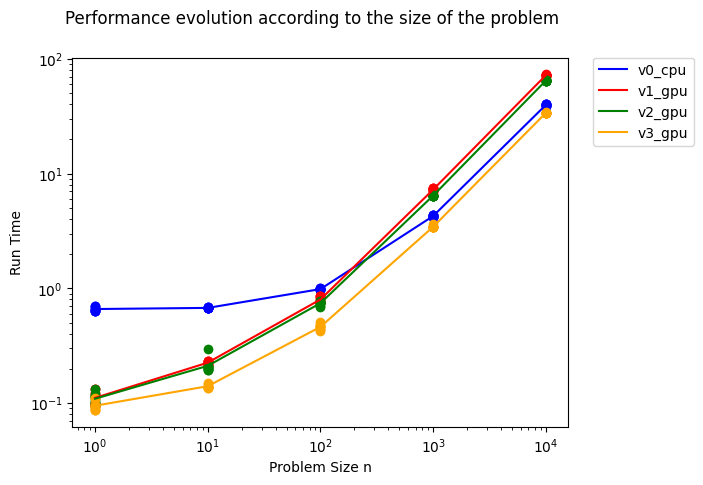

In [11]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v1_v2_v3_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v1_gpu" : "red", "v2_gpu": "green", "v3_gpu": "orange"}
versions = ["v0_cpu", "v1_gpu", "v2_gpu", "v3_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Nous avons (enfin) réussi à obtenir un code qui est plus rapide que le code CPU fournit de base. 

De la même manière que sur le graph précédent, la différence n'est pas si flagrante sur le graphe avec une échelle logarithmique. Si vous passez à une échelle linéaire, vous verrez qu'il y a une différence d'environ 10 secondes pour n = 10000 entre le code en version CPU et le code en version GPU (ce qui correspond à une amélioration d'un peu moins de 20%).

Plus haut dans ce rapport nous avons expliqué que le problème des GPUs était souvent un problème de latence. (C'est pourquoi pour des petites valeurs de n, la version GPU est meilleure mais la latence rencontrée à chaque nouvelle génération la rend de plus en plus mauvaise).

Il était très important pour moi de rendre un programme au moins aussi bon que le programme fournit de base sur le cas par défaut (donc ici, avec w = 32 et h = 32).

Maintenant que cet objectif est atteint, nous allons parler du point fort des GPUs, la bande passante! 

#### BANDE PASSANTE

Nous allons désormais fixer n à 100, et faire évoluer la taille de la grille (w et h). Dans la suite, w = h et ils vont évoluer de 16 à 128.


#### Récupération des résultats

In [33]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
WIDTH_HEIGHT = [(16, 16), (32, 32), (64, 64), (128, 128)]
nbValues = 10
values = {"v0_cpu": [], "v3_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_cpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in WIDTH_HEIGHT:
        args = ("./micro_aevol_cpu", "-n", str(100), "-w", str(n[0]), "-h", str(n[1]))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

os.chdir("v3/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in WIDTH_HEIGHT:
        args = ("./micro_aevol_gpu", "-n",  str(100), "-w", str(n[0]), "-h", str(n[1]))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v3_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)


f = open("stats_bandwidth.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0][0]) + ", " + str(val[0][1]) + ", " + str(val[1]) + "\n")
    
version = "v3_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0][0]) + ", " + str(val[0][1]) + ", " + str(val[1]) + "\n")
    
f.close()

print("Done")

#### Affichage des résultats

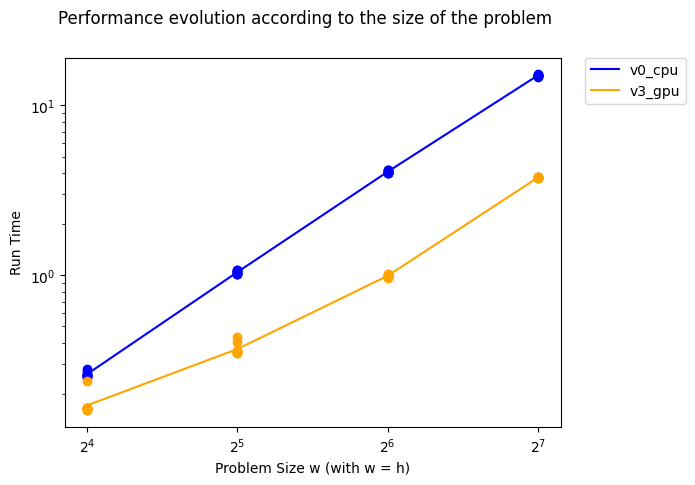

In [1]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_bandwidth_fixed.csv',header=None,names=['version','w', 'h', 'runtime'],dtype={
                     'version': str,
                     'w': int,
                     'h': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue","v3_gpu": "orange"}
versions = ["v0_cpu", "v3_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'w', 'h']).mean().reset_index()
    
    
    ax1.plot(mean_stats['w'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['w'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log', base=2)
ax1.set_xlabel('Problem Size w (with w = h)')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

#### Analyse des résultats

Nous remarquons que la version GPU est bien meilleure que la version CPU lorsque l'on fait augmenter la taille de la grille. Le temps de calcul a été divisé par 8 environ.

### Conclusion et pistes d'améliorations

Je me suis arrêté ici pour la rédaction de ce rapport. J'ai essayé plusieurs autres méthodes qui n'ont pas été concluantes et je vous ai mis le meilleur résultat que j'ai obtenu. Voici quelques pistes d'améliorations:

#### Changer les structures de données

En effet, manipuler les génomes sous forme de tableaux de char n'est pas forcément un bon choix car c'est une structure qui est lourde. Nous pourrions utiliser un bit set afin d'alléger les transferts de données et de gagner de la performance à ce niveau-là. (Tentative de ma v4 qui n'a pas conclu).

#### Faire un meilleur usage de la mémoire partagée

Je n'ai que très peu utilisé la mémoire partagée dans ce projet... Chaque fois que j'ai essayé de l'utiliser les résultats n'étaient pas très significatifs. Peut-être est-ce dû au fait qu'il y a d'autre choses à optimiser qui auront plus d'impact avant d'essayer de faire un bon usage de cette mémoire? Je me suis peut-être arrêté trop tôt? Je ne sais pas mais ce serait une piste à explorer.

#### Modifier les algorithmes

Je n'ai appliqué aucune modifications conseillée dans les slides du projet (slide 7/9 de la présentation), les appliquer pourrait grandement améliorer les performances. J'ai choisi de ne pas faire cela en priorité car je voulais axer ma réflexion sur le GPU et ses spécificités.